In [2]:
import pandas as pd
import geopandas as gpd
import requests

# Data Preprocessing

### Read data

In [3]:
token = "vAtl2Z7zE587vSL1K0jPGUqgw"

Download zipcode data

In [4]:
raw_zipcode = gpd.read_file("nyc_zipcodes.shp")
raw_zipcode

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((950767.507 172848.969, 950787.510 17..."
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995877.318 203206.075, 995968.511 20..."
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((997731.761 219560.922, 997641.948 21..."


Download zillow data

In [5]:
raw_zillow = pd.read_csv("zillow_rent_data.csv")
raw_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1606.206406,...,1994.653463,2027.438438,2042.237444,2049.325559,2016.531345,2023.438976,2031.558202,2046.144009,2053.486247,2055.771355
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1257.814660,...,1749.697900,1738.217986,1747.305840,1758.407295,1758.891075,1762.980879,1771.751591,1779.338402,1795.384582,1799.631140
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,1701.217520,1706.900064,1706.067787,1723.722320,1735.484670,1752.132904,1756.990323,1754.429516,1757.602011,1755.031490
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,1419.480272,1458.063897,1471.726681,1466.734658,1456.175660,1462.478506,1466.267391,1490.237063,1488.180414,1494.366097
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783


Download 311 data with API

In [ ]:
url_311_1 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2015-01-01\' and \'2017-01-01\'&$limit=100000000'
url_311_2 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2017-01-01\' and \'2019-01-01\'&$limit=100000000'
url_311_3 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2019-01-01\' and \'2021-01-01\'&$limit=100000000'
url_311_4 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2021-01-01\' and \'2023-01-01\'&$limit=100000000'
url_311_5 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2023-01-01\' and \'2023-10-01\'&$limit=100000000'


In [99]:
# API endpoint URL
url_311_1 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2023-09-30\' and \'2023-10-01\'&$limit=100000'

# Set up the headers with the API token
headers = {'X-App-Token': token}

# Make the API request
response = requests.get(url_311, headers=headers)
data = response.json()

# Print the data
raw_311_20231001= pd.DataFrame(data)
raw_311_20231001.head()

KeyboardInterrupt: 

In [95]:
raw_311.to_excel("raw_311_2023.xlsx")

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,location,taxi_pick_up_location,facility_type,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,due_date,vehicle_type,taxi_company_borough
0,58970426,2023-09-30T00:00:00.000,2023-10-03T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Food Cart Vendor,10003,18 UNION SQUARE EAST,...,"{'latitude': '40.7348900594353', 'longitude': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58958037,2023-09-29T23:59:53.000,2023-09-30T01:04:04.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11433,107-40 160 STREET,...,"{'latitude': '40.696276248515204', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58963337,2023-09-29T23:59:40.000,2023-12-06T14:15:02.000,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,Street,10002,229 CHRYSTIE STREET,...,"{'latitude': '40.723202995922456', 'longitude'...","229 CHRYSTIE STREET, MANHATTAN (NEW YORK), NY,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,58967293,2023-09-29T23:59:10.000,2023-09-30T00:01:37.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11216,6 ALBANY AVENUE,...,"{'latitude': '40.6805991000235', 'longitude': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58957297,2023-09-29T23:59:00.000,2023-11-09T11:51:34.000,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,Street,10002,229 CHRYSTIE STREET,...,"{'latitude': '40.723202995922456', 'longitude'...","229 CHRYSTIE STREET, MANHATTAN (NEW YORK), NY,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359897,56418136,2023-01-01T00:00:46.000,2023-01-01T01:01:43.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11234,1621 EAST 51 STREET,...,"{'latitude': '40.62066491675458', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2359898,56418795,2023-01-01T00:00:45.000,2023-01-01T01:24:10.000,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10001,15 HUDSON BOULEVARD,...,"{'latitude': '40.75487501846257', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2359899,56416252,2023-01-01T00:00:42.000,2023-01-01T17:34:15.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10453,1871 SEDGWICK AVENUE,...,"{'latitude': '40.85384789145288', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2359900,56417527,2023-01-01T00:00:09.000,2023-01-01T00:36:06.000,NYPD,New York City Police Department,Illegal Fireworks,N/A,Street/Sidewalk,11218,AVENUE C,...,"{'latitude': '40.640914779776715', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Download tree data with API

In [11]:
# API endpoint URL
url_tree = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json?$limit=10000000000'

# Set up the headers with the API token
headers = {'X-App-Token': token}

# Make the API request
response = requests.get(url_tree, headers=headers)
data = response.json()

# Print the data
raw_tree = pd.DataFrame(data)
raw_tree.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,"{'type': 'Point', 'coordinates': [-73.84421521...",3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.72309177,-73.84421522,1027431.14821,202756.768749
1,09/03/2015,200540,315986,"{'type': 'Point', 'coordinates': [-73.81867945...",21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.79411067,-73.81867946,1034455.70109,228644.837379
2,09/05/2015,204026,218365,"{'type': 'Point', 'coordinates': [-73.93660770...",3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.71758074,-73.9366077,1001822.83131,200716.891267
3,09/05/2015,204337,217969,"{'type': 'Point', 'coordinates': [-73.93445615...",10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.71353749,-73.93445616,1002420.35833,199244.253136
4,08/30/2015,189565,223043,"{'type': 'Point', 'coordinates': [-73.97597938...",21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.66677776,-73.97597938,990913.775046,182202.425999


### Removing unnecessary columns

In [12]:
columns_to_drop = raw_zipcode.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
gdf_zipcode_1 = raw_zipcode.drop(columns=columns_to_drop)
gdf_zipcode_1.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [13]:
df_zillow_1 = pd.concat([raw_zillow.iloc[:, [2, 6]], raw_zillow.iloc[:, 9:]], axis=1)
df_zillow_1.head()

,RegionName,City,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,77494,Katy,1606.206406,1612.779844,1622.201575,1630.392427,1632.411500,1636.206864,1644.894632,1643.390762,...,1994.653463,2027.438438,2042.237444,2049.325559,2016.531345,2023.438976,2031.558202,2046.144009,2053.486247,2055.771355
1,77449,Katy,1257.814660,1255.268025,1262.170452,1274.955754,1285.526052,1295.665673,1296.650395,1300.868081,...,1749.697900,1738.217986,1747.305840,1758.407295,1758.891075,1762.980879,1771.751591,1779.338402,1795.384582,1799.631140
2,77084,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1701.217520,1706.900064,1706.067787,1723.722320,1735.484670,1752.132904,1756.990323,1754.429516,1757.602011,1755.031490
3,79936,El Paso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1419.480272,1458.063897,1471.726681,1466.734658,1456.175660,1462.478506,1466.267391,1490.237063,1488.180414,1494.366097
4,11385,New York,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783


In [14]:
df_311_1 = raw_311.loc[:, ['created_date', 'complaint_type', 'incident_zip', "latitude", "longitude"]]
df_311_1.head()

,created_date,complaint_type,incident_zip,latitude,longitude
0,2023-09-30T23:59:58.000,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623
1,2023-09-30T23:59:38.000,Noise - Residential,11361,40.76675595839554,-73.78751847563191
2,2023-09-30T23:59:35.000,Noise - Commercial,10002,40.71949965458691,-73.98486650733275
3,2023-09-30T23:59:34.000,Noise - Residential,11435,40.687499303408536,-73.7972903094197
4,2023-09-30T23:59:28.000,Noise - Residential,11226,40.65220215349917,-73.9579464603267


In [15]:
df_tree_1 = raw_tree.loc[:, ["zipcode", "tree_id", "latitude", "longitude", "x_sp", "y_sp", "status", "health", "spc_common"]]
df_tree_1.head()

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,spc_common
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden


### Remove invalid data points 

Drop duplication

In [16]:
gdf_zipcode_2 = gdf_zipcode_1.drop_duplicates().reset_index(drop=True)
gdf_zipcode_2.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


Drop the rows in df_zillow outsied NYC

In [17]:
index = df_zillow_1[df_zillow_1['City'] != "New York"].index
df_zillow_2 = df_zillow_1.drop(index).reset_index(drop=True)
df_zillow_2 = df_zillow_2.drop(["City"], axis=1)
df_zillow_2.head()

,RegionName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,11385,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,2297.900917,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
1,11208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
2,11236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
3,10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
4,11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


Change the format of rent dataframe

In [18]:
df_rent_1 = pd.DataFrame(columns=["zipcode", "date", "rent"])
temp_data = []
for index, row in df_zillow_2.iterrows():
    for i in range(len(row)-1):
        temp_data.append({"zipcode": str(int(row[0])), "date": df_zillow_2.columns[i+1], "rent": row[i+1]})
df_rent_1 = pd.concat([df_rent_1, pd.DataFrame(temp_data)], ignore_index=True)
df_rent_1.dropna(subset=['rent'], inplace=True)
df_rent_1 = df_rent_1.reset_index(drop=True)
df_rent_1.head()

,zipcode,date,rent
0,11385,2015-02-28,2087.527084
1,11385,2015-04-30,2149.924252
2,11385,2015-05-31,2166.263698
3,11385,2015-06-30,2148.992886
4,11385,2015-07-31,2190.098591


Drop all rows in df_tree and df_311 with null values.

In [19]:
df_311_1 = df_311_1.dropna()
df_tree_1 = df_tree_1.dropna()

### Normalize column names & column types where needed

Normalize the name of zipcode colunms

In [20]:
df_311_1.rename(columns={'incident_zip': 'zipcode', 'created_date': 'date'}, inplace=True)
df_311_1.head()

,date,complaint_type,zipcode,latitude,longitude
0,2023-09-30T23:59:58.000,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623
1,2023-09-30T23:59:38.000,Noise - Residential,11361,40.76675595839554,-73.78751847563191
2,2023-09-30T23:59:35.000,Noise - Commercial,10002,40.71949965458691,-73.98486650733275
3,2023-09-30T23:59:34.000,Noise - Residential,11435,40.687499303408536,-73.7972903094197
4,2023-09-30T23:59:28.000,Noise - Residential,11226,40.65220215349917,-73.9579464603267


In [21]:
gdf_zipcode_2.rename(columns={'ZIPCODE': 'zipcode', 'geometry': 'location'}, inplace=True)
gdf_zipcode_2 = gdf_zipcode_2.set_geometry('location')
gdf_zipcode_2.head()

,zipcode,location
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [22]:
df_tree_1.rename(columns={'spc_common': 'species'}, inplace=True)
df_tree_1.head()

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,species
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden


Transform date columns from strings to datetime Python objects


In [23]:
df_311_1['date'] = pd.to_datetime(df_311_1['date'])
print(df_311_1.dtypes) 

date              datetime64[ns]
complaint_type            object
zipcode                   object
latitude                  object
longitude                 object
dtype: object


In [24]:
df_rent_1['date'] = pd.to_datetime(df_rent_1['date'])
print(df_rent_1.dtypes) 

zipcode            object
date       datetime64[ns]
rent              float64
dtype: object


### Normalize the Spatial Reference Identifiers (SRID) of any geometry.

In [25]:
from shapely.geometry import Point

In [26]:
gdf_zipcode_2 = gdf_zipcode_2.to_crs('EPSG:4326')
gdf_zipcode_2.head()

,zipcode,location
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [27]:
print(gdf_zipcode_2.crs)

EPSG:4326


In [28]:
df_tree_1['location'] = [Point(xy) for xy in zip(df_tree_1.longitude, df_tree_1.latitude)]
gdf_tree_1 = gpd.GeoDataFrame(df_tree_1, geometry='location')
gdf_tree_1.crs = 'EPSG:4326'
gdf_tree_1.head()

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,species,location
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple,POINT (-73.84422 40.72309)
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak,POINT (-73.81868 40.79411)
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust,POINT (-73.93661 40.71758)
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust,POINT (-73.93446 40.71354)
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden,POINT (-73.97598 40.66678)


In [29]:
df_311_1['location'] = [Point(xy) for xy in zip(df_311_1.longitude, df_311_1.latitude)]
gdf_311_1 = gpd.GeoDataFrame(df_311_1, geometry='location')
gdf_311_1.crs = 'EPSG:4326'
gdf_311_1.head()

,date,complaint_type,zipcode,latitude,longitude,location
0,2023-09-30 23:59:58,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623,POINT (-73.95918 40.65567)
1,2023-09-30 23:59:38,Noise - Residential,11361,40.76675595839554,-73.78751847563191,POINT (-73.78752 40.76676)
2,2023-09-30 23:59:35,Noise - Commercial,10002,40.71949965458691,-73.98486650733275,POINT (-73.98487 40.71950)
3,2023-09-30 23:59:34,Noise - Residential,11435,40.687499303408536,-73.7972903094197,POINT (-73.79729 40.68750)
4,2023-09-30 23:59:28,Noise - Residential,11226,40.65220215349917,-73.9579464603267,POINT (-73.95795 40.65220)


# Storing Data

## Create database

In [30]:
!createdb group36project

createdb: error: database creation failed: ERROR:  database "group36project" already exists


In [31]:
!psql --dbname group36project -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


## Create a schema.sql file that defines each table’s schema.

In [40]:
from sqlalchemy import create_engine
from geoalchemy2 import Geometry, WKTElement
engine = create_engine('postgresql:///group36project')
conn = engine.connect()
conn.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

In [41]:
# Get the data types of each column
dtypes = gdf_zipcode_2.dtypes

# Create a mapping from pandas data types to SQL data types
type_mapping = {
    'int64': 'INTEGER',
    'float64': 'REAL',
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT',
    'geometry':'geometry(POLYGON,4326)' 
}

# Generate SQL definitions for each column
definitions = []
for column, dtype in dtypes.iteritems():
    sql_type = type_mapping[str(dtype)]
    definitions.append(f'    {column} {sql_type}')

# Generate and print the full CREATE TABLE statement
table_name = 'zipcodes'
sql_zipcode = f'CREATE TABLE IF NOT EXISTS {table_name} (\n    id INTEGER PRIMARY KEY'+',\n'+ ',\n'.join(definitions) + '\n);'

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_55121/101136632.py:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [42]:
# Get the data types of each column
dtypes = gdf_311_1.dtypes

# Create a mapping from pandas data types to SQL data types
type_mapping = {
    'int64': 'INTEGER',
    'float64': 'REAL',
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT',
    'geometry':'geometry(POINT,4326)' 
}

# Generate SQL definitions for each column
definitions = []
for column, dtype in dtypes.iteritems():
    sql_type = type_mapping[str(dtype)]
    definitions.append(f'    {column} {sql_type}')

# Generate and print the full CREATE TABLE statement
table_name = 'complaints'
sql_311 = f'CREATE TABLE IF NOT EXISTS {table_name} (\n    id INTEGER PRIMARY KEY'+',\n'+ ',\n'.join(definitions) + '\n);'

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_55121/597809228.py:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [43]:
# Get the data types of each column
dtypes = gdf_tree_1.dtypes

# Create a mapping from pandas data types to SQL data types
type_mapping = {
    'int64': 'INTEGER',
    'float64': 'REAL',
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT',
    'geometry':'geometry(POINT,4326)' 
}

# Generate SQL definitions for each column
definitions = []
for column, dtype in dtypes.iteritems():
    sql_type = type_mapping[str(dtype)]
    definitions.append(f'    {column} {sql_type}')

# Generate and print the full CREATE TABLE statement
table_name = 'trees'
sql_tree = f'CREATE TABLE IF NOT EXISTS {table_name} (\n    id INTEGER PRIMARY KEY'+',\n'+ ',\n'.join(definitions) + '\n);'

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_55121/1637391997.py:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [44]:
# Get the data types of each column
dtypes = df_rent_1.dtypes

# Create a mapping from pandas data types to SQL data types
type_mapping = {
    'int64': 'INTEGER',
    'float64': 'REAL',
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT',
}

# Generate SQL definitions for each column
definitions = []
for column, dtype in dtypes.iteritems():
    sql_type = type_mapping[str(dtype)]
    definitions.append(f'    {column} {sql_type}')

# Generate and print the full CREATE TABLE statement
table_name = 'rents'
sql_zillow = f'CREATE TABLE IF NOT EXISTS {table_name} (\n    id INTEGER PRIMARY KEY'+',\n'+ ',\n'.join(definitions) + '\n);'

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_55121/1354330607.py:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [45]:
# Write to 'schema.sql' file
with open('schema.sql', 'w') as f:
    f.write(sql_zipcode)
    f.write(sql_311)
    f.write(sql_tree)
    f.write(sql_zillow)

In [46]:
with open('schema.sql') as f:
    with engine.connect() as connection:
        connection.execute(f.read())

## Add data to database

In [47]:
gdf_311_1.to_postgis("complaints", engine, if_exists='append', index=True, index_label='id')

In [48]:
gdf_tree_1.to_postgis("trees", engine, if_exists='append', index=True, index_label='id')

In [49]:
gdf_zipcode_2.to_postgis("zipcodes", engine, if_exists='append', index=True, index_label='id')

In [50]:
df_rent_1.to_sql("rents", engine, if_exists='append', index=True, index_label='id')

39

In [51]:
query = """
SELECT f_geometry_column, coord_dimension, srid, type 
FROM geometry_columns 
WHERE f_table_name = 'trees'
"""
df = pd.read_sql_query(query, engine)
print(df)

  f_geometry_column  coord_dimension  srid   type
0          location                2  4326  POINT


# Understanding Data

In [52]:
from sqlalchemy import text
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as f:
        f.write(query)

### Query 1

In [53]:
QUERY_1_FILENAME = "Query 1"

In [54]:
# Define your SQL query
QUERY_1 = """
SELECT zipcode, COUNT(*) AS complaints_count
FROM complaints
WHERE date BETWEEN '2023-09-04 00:00:00' AND '2023-09-07 00:00:00'
GROUP BY zipcode
ORDER BY complaints_count DESC;
"""

# Execute the query and fetch the results into a pandas DataFrame
df = pd.read_sql_query(QUERY_1, engine)

# Display the DataFrame
print(df)

Empty DataFrame
Columns: [zipcode, complaints_count]
Index: []


In [55]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    for row in result:
        print(row)

In [56]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [57]:
QUERY_2_FILENAME = "Query 2"

In [58]:
# Define your SQL query
QUERY_2 = """
SELECT zipcode, COUNT(*) AS trees_count
FROM trees
GROUP BY zipcode
ORDER BY trees_count DESC
LIMIT 10;
"""

# Execute the query and fetch the results into a pandas DataFrame
df = pd.read_sql_query(QUERY_2, engine)

# Display the DataFrame
print(df)

  zipcode  trees_count
0   10312        21356
1   10314        16330
2   10306        12616
3   10309        12105
4   11234        10838
5   11385        10262
6   11357         9016
7   11207         8293
8   11208         7896
9   11434         7833


In [59]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    for row in result:
        print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8293)
('11208', 7896)
('11434', 7833)


In [60]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query3

In [61]:
QUERY_3_FILENAME = "Query 3"

In [62]:
QUERY_3 = """
SELECT trees_count.zipcode, CAST(ROUND(CAST(rents.rent AS numeric), 2) AS DECIMAL(10,2)) AS average_rent
FROM (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
    ORDER BY trees_count DESC
    LIMIT 10
) AS trees_count
JOIN rents ON trees_count.zipcode = rents.zipcode
WHERE rents.date = '2023-08-31'
ORDER BY trees_count.trees_count DESC;
"""

df = pd.read_sql_query(QUERY_3, engine)

df['average_rent'] = df['average_rent'].apply(lambda x: "{:,.2f}".format(x))

print(df)

  zipcode average_rent
0   10312     1,775.09
1   10314     2,465.47
2   10306     2,331.54
3   10309     1,832.01
4   11234     2,312.31
5   11385     3,064.48
6   11357     2,458.81
7   11207     3,079.09
8   11208     2,737.55
9   11434     2,645.92


In [63]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    for row in result:
        print(row)

('10312', Decimal('1775.09'))
('10314', Decimal('2465.47'))
('10306', Decimal('2331.54'))
('10309', Decimal('1832.01'))
('11234', Decimal('2312.31'))
('11385', Decimal('3064.48'))
('11357', Decimal('2458.81'))
('11207', Decimal('3079.09'))
('11208', Decimal('2737.55'))
('11434', Decimal('2645.92'))


In [64]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query4

In [65]:
QUERY_4_FILENAME = "Query 4"

In [66]:
QUERY_4 = """
(SELECT h_rent.zipcode, h_rent.rent, trees_count.trees_count, complaints_count.complaints_count 
FROM (
    SELECT zipcode, rent 
    FROM rents
    WHERE date = '2023-01-31'
    ORDER BY rent DESC
    LIMIT 5
) AS h_rent
JOIN  (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
) AS trees_count ON h_rent.zipcode = trees_count.zipcode
JOIN (
    SELECT zipcode, COUNT(*) AS complaints_count
    FROM complaints
    WHERE date BETWEEN '2023-12-04 00:00:00' AND '2023-12-07 23:59:59'
    GROUP BY zipcode
) AS complaints_count ON h_rent.zipcode = complaints_count.zipcode)
UNION ALL
(SELECT l_rent.zipcode, l_rent.rent, trees_count.trees_count, complaints_count.complaints_count 
FROM (
    SELECT zipcode, rent 
    FROM rents
    WHERE date = '2023-01-31'
    ORDER BY rent ASC
    LIMIT 5
) AS l_rent
JOIN  (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
) AS trees_count ON l_rent.zipcode = trees_count.zipcode
JOIN (
    SELECT zipcode, COUNT(*) AS complaints_count
    FROM complaints
    WHERE date BETWEEN '2023-12-04 00:00:00' AND '2023-12-07 23:59:59'
    GROUP BY zipcode
) AS complaints_count ON l_rent.zipcode = complaints_count.zipcode)
"""

df = pd.read_sql_query(QUERY_4, engine)
# Display the DataFrame
print(df)

Empty DataFrame
Columns: [zipcode, rent, trees_count, complaints_count]
Index: []


In [67]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    for row in result:
        print(row)

In [68]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query5

In [69]:
QUERY_5_FILENAME = "Query 5"

In [70]:
QUERY_5 = """
SELECT zipcodes.zipcode, COUNT(*) AS trees_count
FROM trees
JOIN zipcodes ON ST_Within(trees.location, zipcodes.location)
GROUP BY zipcodes.zipcode
ORDER BY trees_count DESC
LIMIT 10
"""

# Execute the query and fetch the results into a pandas DataFrame
df = pd.read_sql_query(QUERY_5, engine)

# Display the DataFrame
print(df)

  zipcode  trees_count
0   10312        21356
1   10314        16330
2   10306        12616
3   10309        12105
4   11234        10838
5   11385        10262
6   11357         9016
7   11207         8294
8   11208         7897
9   11434         7833


In [71]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    for row in result:
        print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8294)
('11208', 7897)
('11434', 7833)


In [72]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query6

In [73]:
QUERY_6_FILENAME = "Query 6"

In [74]:
target_point = "POINT(40.80737875669467 -73.96253174434912)"

In [75]:
target_point = "POINT(-73.96253174434912 40.80737875669467)"
QUERY_6 = f"""
SELECT tree_id AS id, species, health, status, ST_AsText(location) AS location 
FROM trees 
WHERE ST_DWithin(ST_Transform(location, 4326)::geography, ST_GeomFromText('{target_point}', 4326)::geography, 804.672);
"""

# Execute the query and fetch the results into a pandas DataFrame
df = pd.read_sql_query(QUERY_6, engine)

# Display the DataFrame
print(df)

          id           species health status                         location
0     198514           pin oak   Good  Alive   POINT(-73.9620798 40.80230109)
1     209919  London planetree   Good  Alive  POINT(-73.96331506 40.80881155)
2     209921  London planetree   Good  Alive  POINT(-73.96340334 40.80874458)
3     203887        willow oak   Good  Alive  POINT(-73.96071917 40.80572583)
4     196440      American elm   Fair  Alive  POINT(-73.96412322 40.81114538)
...      ...               ...    ...    ...                              ...
2767  186783       scarlet oak   Good  Alive  POINT(-73.96550795 40.80376221)
2768  203888  Japanese zelkova   Fair  Alive  POINT(-73.96115906 40.80590977)
2769  203997  London planetree   Good  Alive  POINT(-73.96065411 40.80499024)
2770  203998  London planetree   Good  Alive   POINT(-73.96055964 40.8049499)
2771  187077            ginkgo   Good  Alive  POINT(-73.96002723 40.80075951)

[2772 rows x 5 columns]


In [76]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

# Visualizing Data

Visualization 1

In [77]:
query_visual_1 = """
WITH TopComplaintTypes AS (
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM complaints
    WHERE date BETWEEN '2023-09-04 00:00:00' AND '2023-09-07 23:59:59'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3
)

SELECT DATE_TRUNC('day', date::timestamp) AS truncated_date,
       complaint_type,
       COUNT(*) AS complaint_count
FROM complaints
WHERE complaint_type IN (SELECT complaint_type FROM TopComplaintTypes)
      AND date BETWEEN '2023-11-04 00:00:00' AND '2023-12-07 23:59:59'
GROUP BY truncated_date, complaint_type
ORDER BY truncated_date, complaint_count DESC;


"""

# Execute the query using pandas
df = pd.read_sql_query(query_visual_1, engine)
print(df)

Empty DataFrame
Columns: [truncated_date, complaint_type, complaint_count]
Index: []


In [78]:
df_complaint_type = df.drop_duplicates(subset = 'complaint_type')["complaint_type"]
df_complaint_type

Series([], Name: complaint_type, dtype: object)

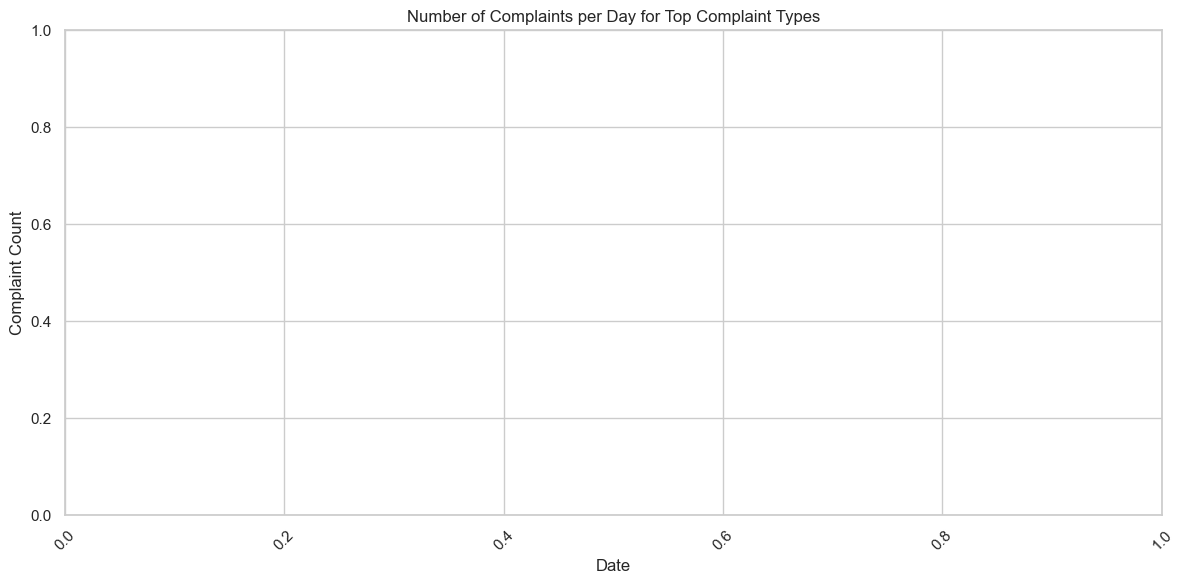

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'truncated_date' to datetime for proper plotting
df['truncated_date'] = pd.to_datetime(df['truncated_date'])

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='truncated_date', y='complaint_count', hue='complaint_type', data=df, marker='o')
plt.title('Number of Complaints per Day for Top Complaint Types')
plt.xlabel('Date')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Visualization 2

In [80]:
query_visual_2 = """
SELECT complaint_type, COUNT(*) AS complaints_count
FROM complaints
WHERE date BETWEEN '2023-09-04 00:00:00' AND '2023-09-07 00:00:00' AND zipcode = '10027'
GROUP BY complaint_type
ORDER BY complaints_count DESC
LIMIT 10
"""
df = pd.read_sql_query(query_visual_2, engine)
print(df)

Empty DataFrame
Columns: [complaint_type, complaints_count]
Index: []


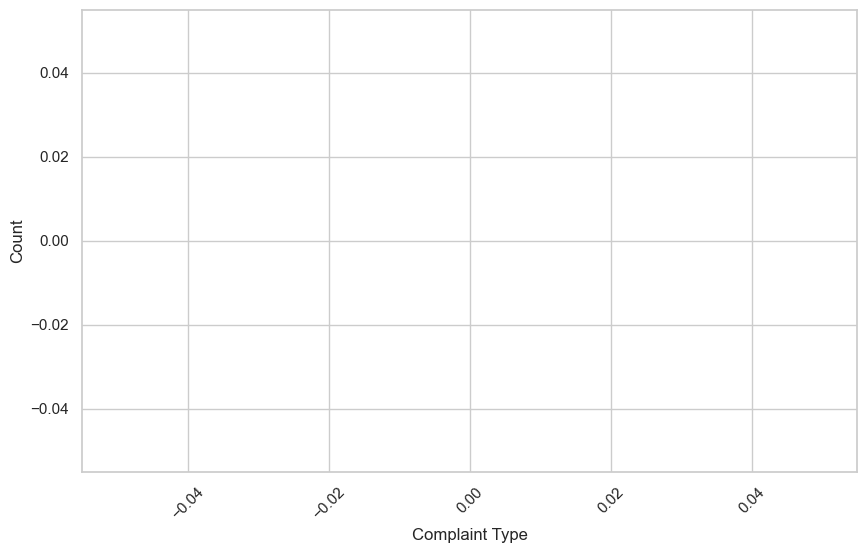

In [81]:
plt.figure(figsize=(10, 6))
plt.bar(df['complaint_type'], df['complaints_count'], color = "blue")
plt.xlabel('Complaint Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Visualization 3

In [82]:
query_visual_3_tree = """
SELECT rents.zipcode AS zipcode, AVG(rents.rent) AS average_rent, COUNT(*) AS trees_count
FROM rents
JOIN trees ON rents.zipcode =  trees.zipcode
WHERE rents.date BETWEEN '2015-01-01' AND '2023-12-30'
GROUP BY rents.zipcode
ORDER BY average_rent DESC
"""
df_3_tree = pd.read_sql_query(query_visual_3_tree, engine)
print(df_3_tree)

    zipcode  average_rent  trees_count
0     10282   7029.339152         5520
1     10007   6484.824436        27378
2     10013   4819.141683       118860
3     10069   4615.526230         6160
4     10001   4094.657754        89250
..      ...           ...          ...
138   11214   1808.879065       236550
139   10458   1701.725740       285868
140   10312   1666.821937       491188
141   10462   1640.212801       331936
142   10309   1626.081921       121050

[143 rows x 3 columns]


In [83]:
query_visual_3_complaints = """
SELECT rents.zipcode AS zipcode, AVG(rents.rent) AS average_rent, COUNT(*) as complaints_count
FROM rents
JOIN complaints ON rents.zipcode = complaints.zipcode
WHERE complaints.date BETWEEN '2015-01-01' AND '2023-12-30' AND rents.date BETWEEN '2015-01-01' AND '2023-12-30'
GROUP BY rents.zipcode
ORDER BY average_rent DESC
"""
df_3_complaints = pd.read_sql_query(query_visual_3_complaints, engine)
print(df_3_complaints)

    zipcode  average_rent  complaints_count
0     10282   7029.339152             13968
1     10007   6484.824436            257256
2     10162   4968.739502               140
3     10013   4819.141683            988995
4     10069   4615.526230             26125
..      ...           ...               ...
140   11214   1808.879065           1118910
141   10458   1701.725740           2672225
142   10312   1666.821937            285338
143   10462   1640.212801           1758326
144   10309   1626.081921             74040

[145 rows x 3 columns]


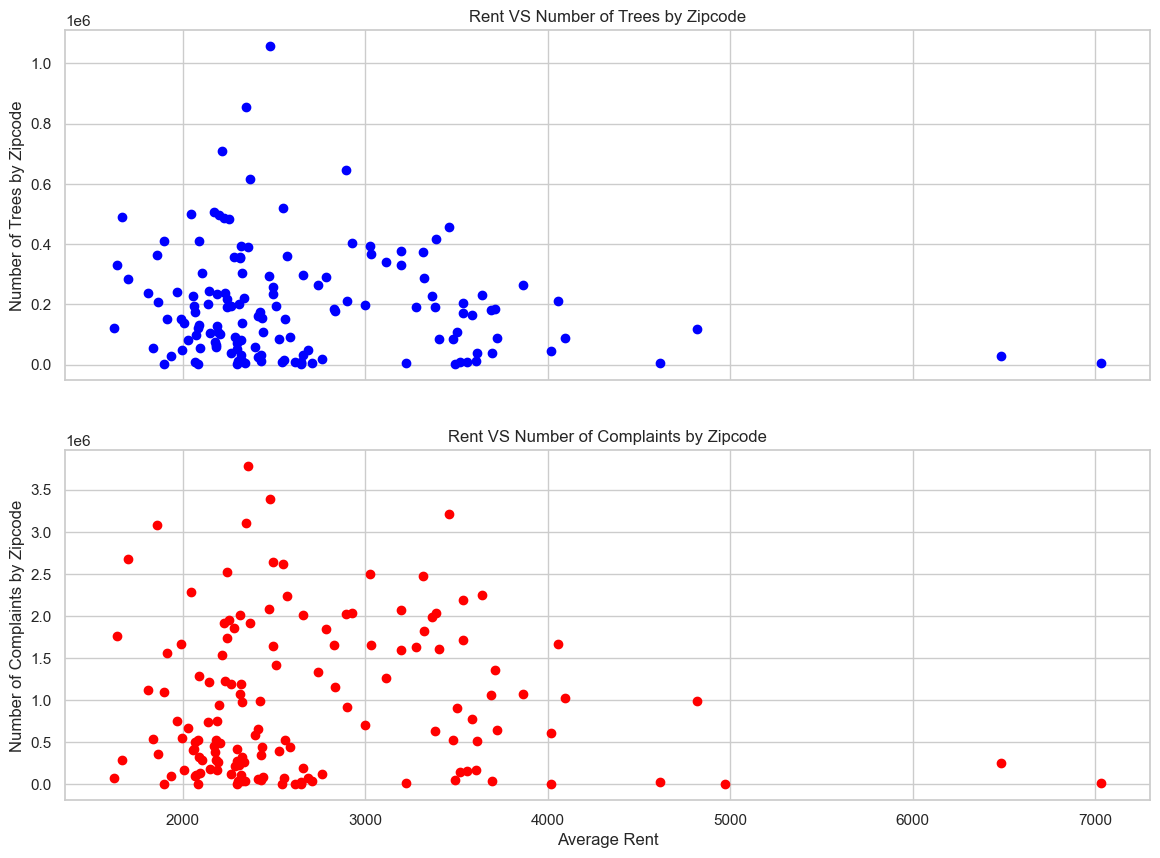

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.scatter(df_3_tree['average_rent'], df_3_tree['trees_count'], color='blue')
ax1.set_ylabel('Number of Trees by Zipcode')
ax1.set_title('Rent VS Number of Trees by Zipcode')
ax1.grid(True)
ax2.scatter(df_3_complaints['average_rent'], df_3_complaints['complaints_count'], color='red')
ax2.set_ylabel('Number of Complaints by Zipcode')
ax2.set_xlabel('Average Rent')
ax2.set_title('Rent VS Number of Complaints by Zipcode')
ax2.grid(True)
plt.show()


Visualization 4

In [85]:
query_visual_4 = """
SELECT
  FLOOR(rents.rent / 1000) * 1000 AS rent_bin,
  complaints.zipcode,
  COUNT(DISTINCT complaints.id) AS num_complaints
FROM
  rents
JOIN
  complaints ON rents.zipcode = complaints.zipcode
WHERE
  complaints.date BETWEEN '2023-12-01' AND '2023-12-06'
GROUP BY
  rent_bin, complaints.zipcode
ORDER BY
  rent_bin, complaints.zipcode;
"""

visual_4= pd.read_sql_query(query_visual_4, engine)
print(visual_4)

Empty DataFrame
Columns: [rent_bin, zipcode, num_complaints]
Index: []


In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
visual_4['rent_bin'] = pd.Categorical(visual_4['rent_bin'])
# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='rent_bin', y='num_complaints', data=visual_4)

# Set labels and title
plt.xlabel('Average Rent ($1000 bins)')
plt.ylabel('Number of 311 Complaints')
plt.title('Boxplot of 311 Complaints by Average Rent in December 2023')

# Show the plot
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1000x600 with 0 Axes>

Visualization 5

In [87]:
target_point = "POINT(-73.96253174434912 40.80737875669467)"
query_visual_5 = f"""
SELECT ST_AsText(location) AS location
FROM complaints 
WHERE ST_DWithin(location::geography, ST_GeomFromText('{target_point}')::geography, 1000) AND date BETWEEN '2023-01-01' AND '2023-12-31'
"""
df_5 = pd.read_sql_query(query_visual_5, engine)
print(df_5)

                                           location
0       POINT(-73.95260757339591 40.81166480566812)
1      POINT(-73.95302702883166 40.805972420859355)
2      POINT(-73.95302702883166 40.805972420859355)
3       POINT(-73.95548445294015 40.80427990061059)
4       POINT(-73.95529594898062 40.80528439709217)
...                                             ...
23541   POINT(-73.95642084980501 40.80296279006334)
23542  POINT(-73.95283188286473 40.806095853791454)
23543  POINT(-73.95934872471949 40.799475312083196)
23544   POINT(-73.95642084980501 40.80296279006334)
23545   POINT(-73.95369206196123 40.80541276604917)

[23546 rows x 1 columns]


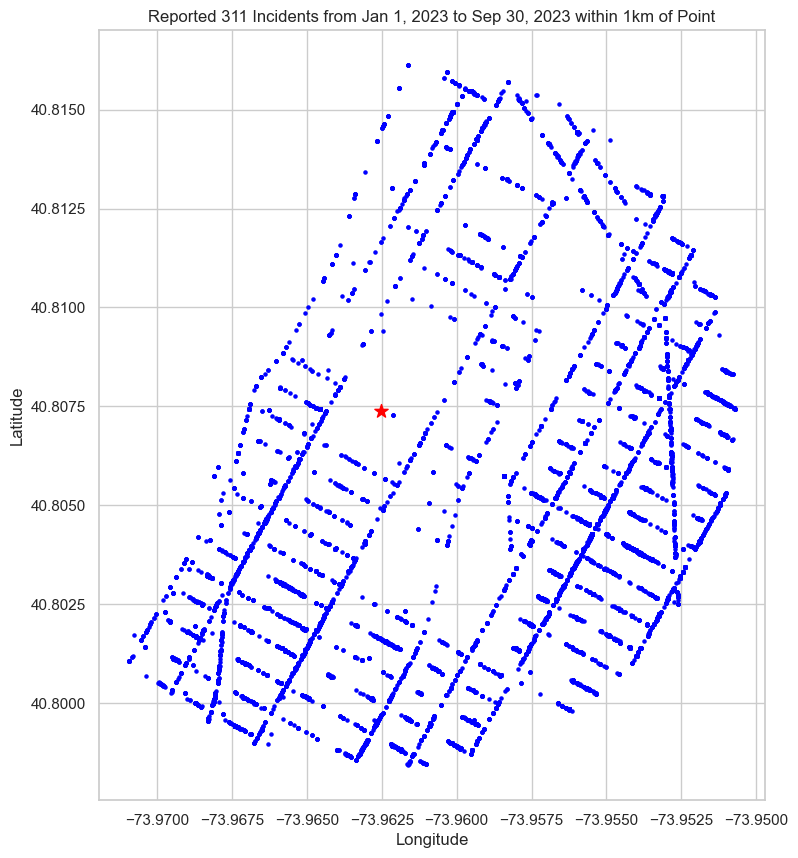

In [88]:
from shapely import wkt

df_5['geometry'] = df_5['location'].apply(wkt.loads)

# Create  GeoDataFrame
gdf = gpd.GeoDataFrame(df_5, geometry='geometry')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=5)

# Plot the target point
target_point_geom = wkt.loads(target_point)
target_gdf = gpd.GeoSeries([target_point_geom], crs="EPSG:4326")
target_gdf.plot(ax=ax, color='red', markersize=100, marker='*')  # Changed marker style for visibility

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Reported 311 Incidents from Jan 1, 2023 to Sep 30, 2023 within 1km of Point')

# Show the plot
plt.show()

Visualization 6

In [89]:
query_visual_6_request = """
SELECT ST_AsText(location) AS request_location
FROM complaints 
WHERE complaint_type = 'New Tree Request'
"""
df_6_request = pd.read_sql_query(query_visual_6_request, engine)
df_6_request['request_location'] = df_6_request['request_location'].apply(wkt.loads)
print(df_6_request)

                                    request_location
0      POINT (-73.86121923025509 40.851123167367014)
1       POINT (-73.99100425747874 40.76272738277269)
2       POINT (-73.95390843511196 40.64421877479377)
3      POINT (-73.80776061338688 40.720328269590894)
4      POINT (-73.97741559312212 40.638497426185786)
...                                              ...
18618   POINT (-73.86479895306637 40.88608938553802)
18619  POINT (-73.86301112605423 40.883186139707405)
18620  POINT (-73.87826315023251 40.704510258029565)
18621  POINT (-73.87831342347583 40.704631080952076)
18622   POINT (-73.87843908235571 40.70494686196376)

[18623 rows x 1 columns]


In [90]:
query_visual_6_tree = """
SELECT ST_AsText(location) AS tree_location
FROM trees 
"""
df_6_tree = pd.read_sql_query(query_visual_6_tree, engine)
df_6_tree['tree_location'] = df_6_tree['tree_location'].apply(wkt.loads)
print(df_6_tree)

                           tree_location
0       POINT (-73.84421522 40.72309177)
1       POINT (-73.81867946 40.79411067)
2        POINT (-73.9366077 40.71758074)
3       POINT (-73.93445616 40.71353749)
4       POINT (-73.97597938 40.66677776)
...                                  ...
652162  POINT (-73.94373349 40.57860297)
652163  POINT (-73.96830596 40.69520351)
652164  POINT (-73.98396002 40.73927037)
652165   POINT (-73.85717727 40.7167409)
652166  POINT (-74.00489247 40.73991341)

[652167 rows x 1 columns]


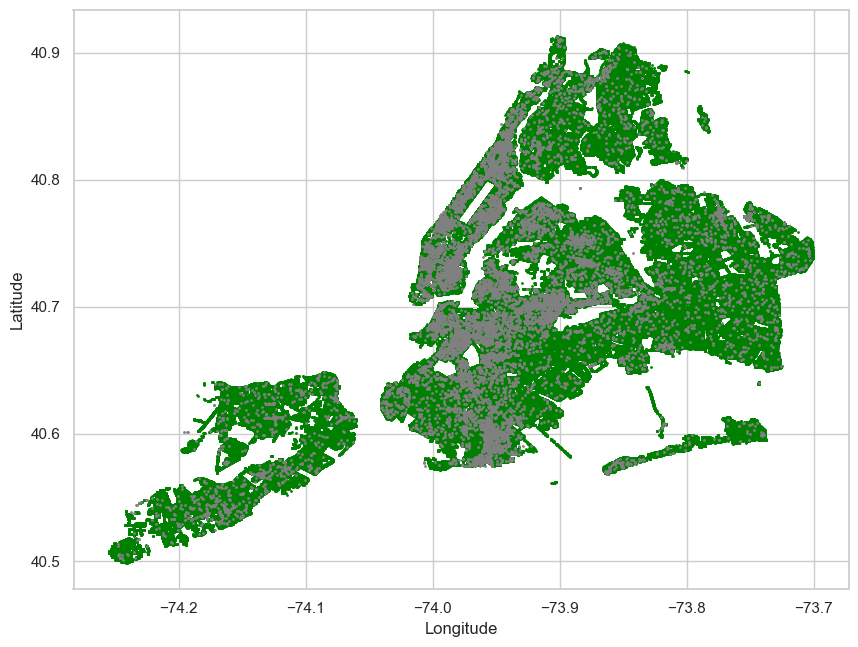

In [93]:
# Create  GeoDataFrame
gdf_tree = gpd.GeoDataFrame(df_6_tree, geometry='tree_location')
gdf_request = gpd.GeoDataFrame(df_6_request, geometry='request_location')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
gdf_tree.plot(ax=ax, color='green', markersize=1)
gdf_request.plot(ax=ax, color='grey', markersize=1)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('')

# Show the plot
plt.show()